In [38]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
# import tensorflow as tf
import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split


In [13]:
data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/tiles'

x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('].png'):
        x.append(os.path.join(data_dir, filename))
        
    if filename.endswith('labelled.png'):
        y.append(os.path.join(data_dir, filename))

            


X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.01, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [14]:
print("Dataset Sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Dataset Sizes:
Training set: 882 samples
Validation set: 98 samples
Test set: 10 samples


In [111]:
a = mask_arr == 1
np.shape(a)

(512, 512)

In [136]:
import numpy as np
from PIL import Image

j= 100

mask_img = Image.open(y[j])
mask_arr = np.array(mask_img) #(512, 512)
unique = np.arange(1, 13, 1) #1:12


# Create an empty array to store the channels
channels = np.zeros((mask_arr.shape[0], mask_arr.shape[1], 13), dtype=np.uint8) # 13 including background

# Assign the pixel values to the corresponding channels
for i, value in enumerate(unique):
    channels[:, :, i] = (mask_arr == value).astype(np.uint8) * 255


print(channels[:, :].shape)

(512, 512, 13)


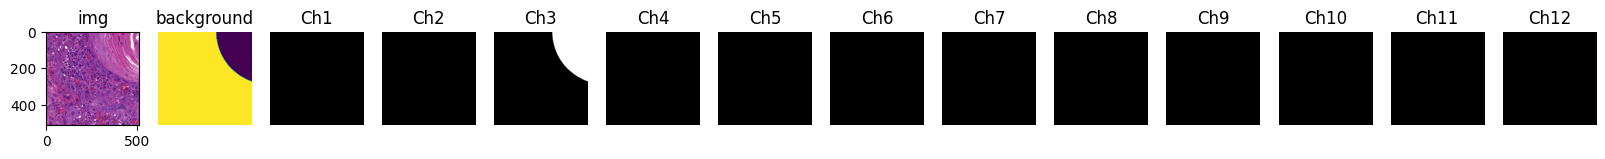

(512, 512, 3)

In [139]:
fig, axs = plt.subplots(1, 14, figsize=(20, 10))


img = Image.open(x[j])
img_arr = np.array(img)
axs[0].imshow(img_arr)
axs[0].set_title(f'img')


axs[1].imshow(mask_arr == 0)
axs[1].axis('off')
axs[1].set_title('background')

for i in range(2,14):
    axs[i].imshow(channels[:, :, i-1], cmap='gray')  # Use 'cmap='gray'' for grayscale images
    axs[i].axis('off')  # Remove axes
    axs[i].set_title(f'Ch{i-1}')

plt.show()
np.shape(img_arr)

In [174]:
## gen
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, list_lables, batch_size=2, shuffle=True,aug=True):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.batch_size = batch_size
        self.list_labels = list_lables
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.unique = np.arange(1, 13, 1)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_lable_paths = [self.list_labels[k] for k in indexes]
        
        # Generate data
        X,y = self.__data_generation(list_IDs_paths,list_lable_paths)

        return X,y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_lable_paths):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_lable_paths)):
            # Store sample
            img_arr = Image.open(sample_path)
            img_arr = img_arr.convert("L")
            img_arr = img_arr.resize((512, 512))
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr = np.divide(img_arr, np.max(img_arr))  # normalize

            # Store label
            lbl_arr = Image.open(label_path)
            lbl_arr = lbl_arr.resize((512, 512))
            lbl_arr = np.array(lbl_arr)
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], 13), dtype=np.uint8) # 13 including background

            for i, value in enumerate(self.unique):
                channels[:, :, i+1] = (lbl_arr == value).astype(np.uint8) * 255
            channels[:, :, 0] = (lbl_arr == 0)    
            lbl_arr = channels
            
            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else: 
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images


    def viz(self, x_images,y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            
            y_mask = y_images[dx]

                
            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, 14, figsize=(20, 10))


            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')


            axs[1].imshow(y_mask[:,:,0])
            axs[1].axis('off')
            axs[1].set_title('background')

            for i in range(2,14):
                axs[i].imshow(y_mask[:, :, i-1], cmap='gray')  # Use 'cmap='gray'' for grayscale images
                axs[i].axis('off')  # Remove axes
                axs[i].set_title(f'Ch{i-1}')

            plt.show()

            
        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[i])} and for masks {np.shape(y_images[i])}')
        print(f'max value for images is {np.max(x_images[i])} and for masks {np.max(y_images[i])}')
        print(f'min value for images is {np.min(x_images[i])} and for masks {np.min(y_images[i])}')
        print(f'number of unique values in images is {len(np.unique(x_images[i]))} and for masks {np.unique(y_images[i])}')

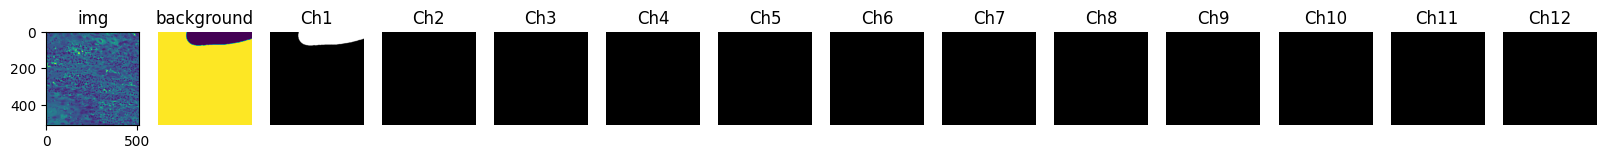

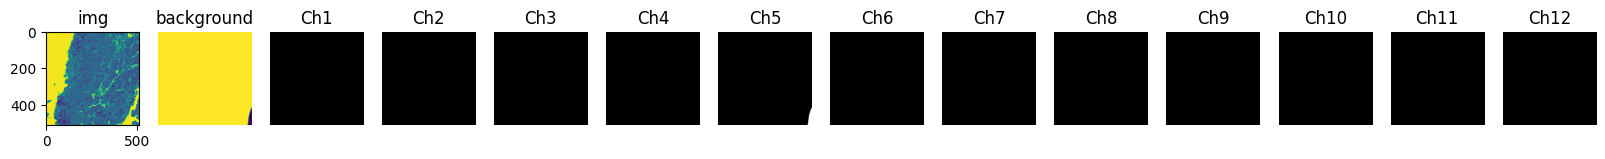

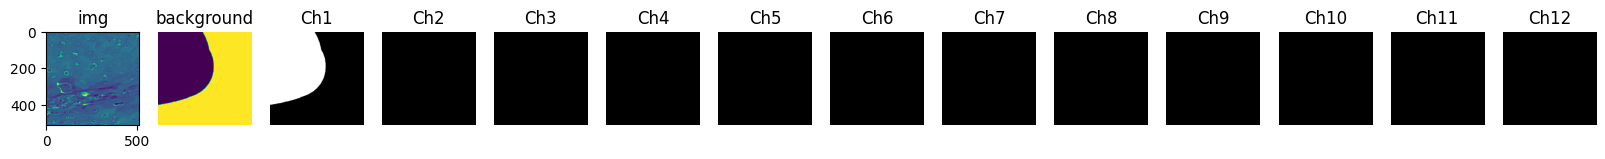

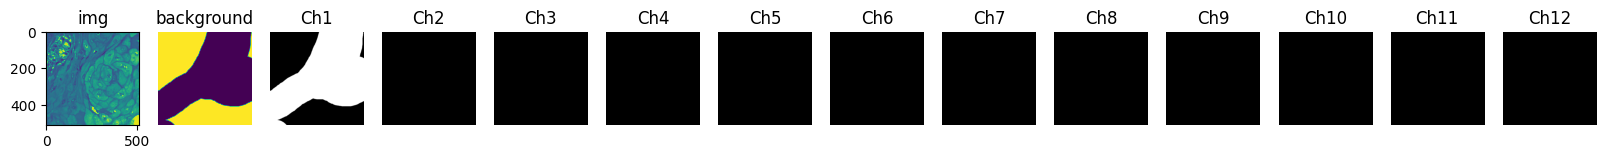

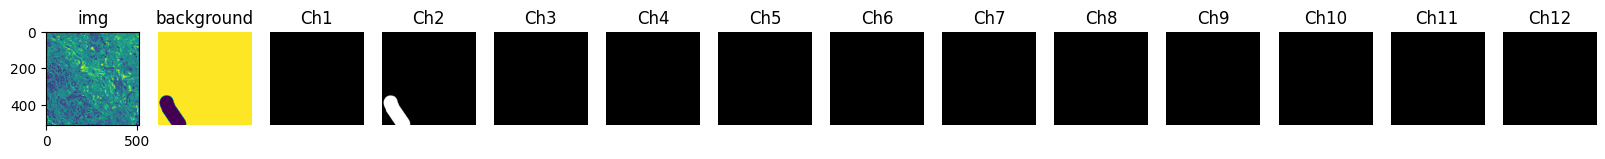

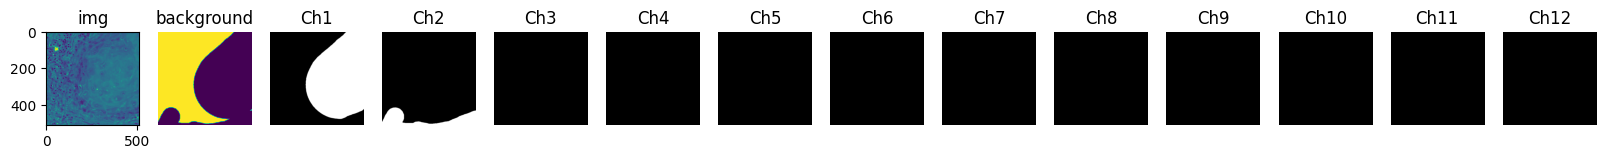

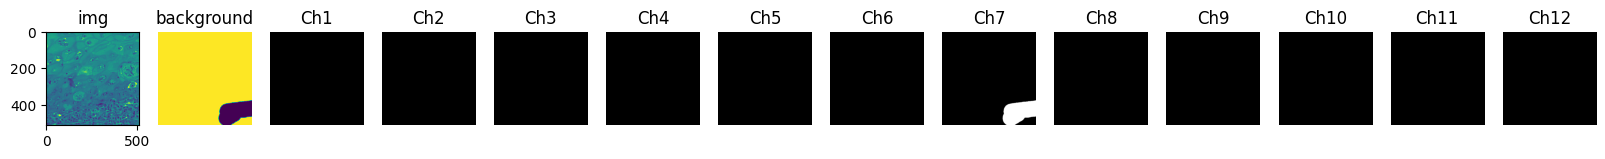

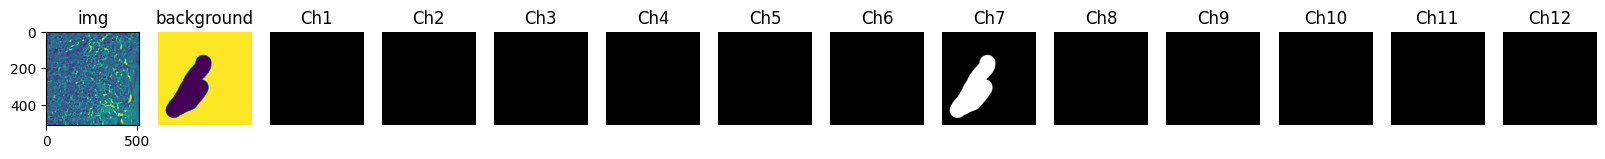

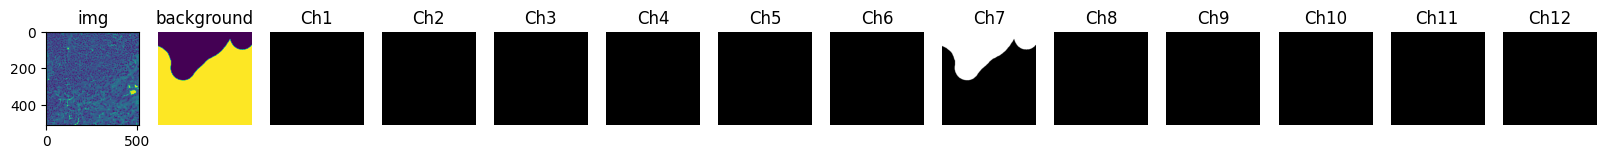

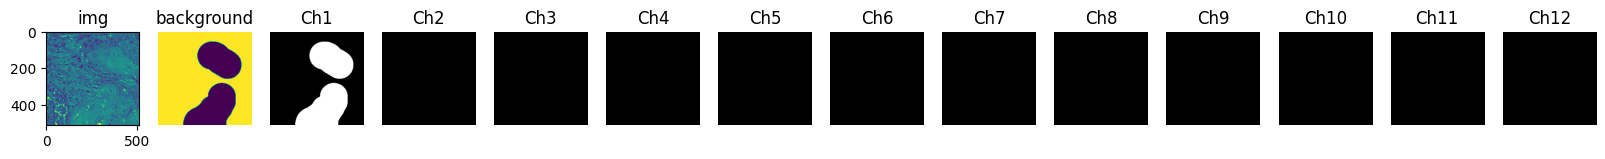

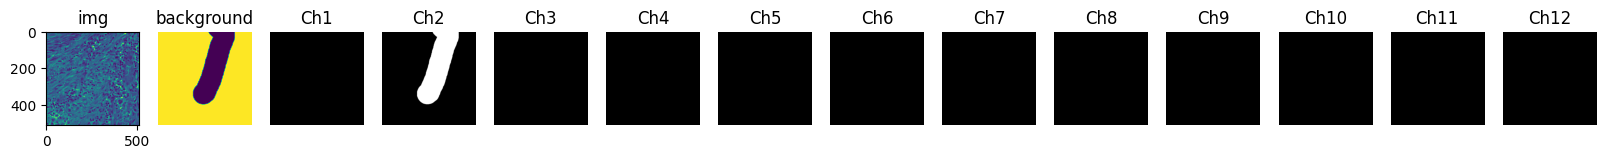

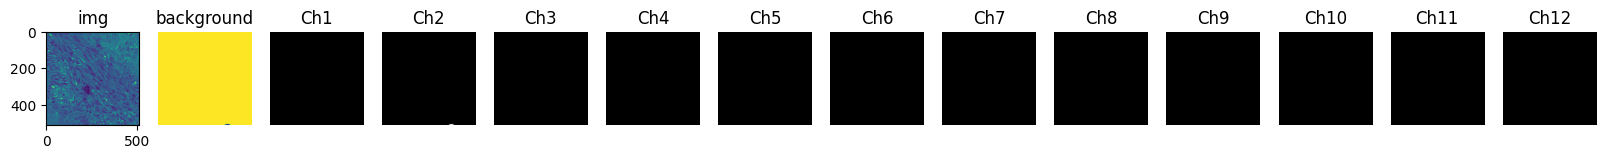

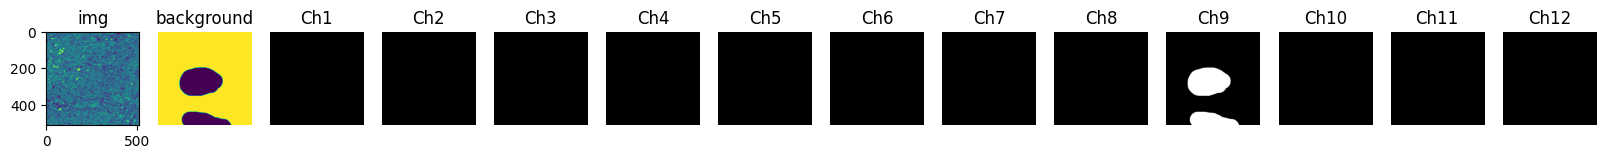

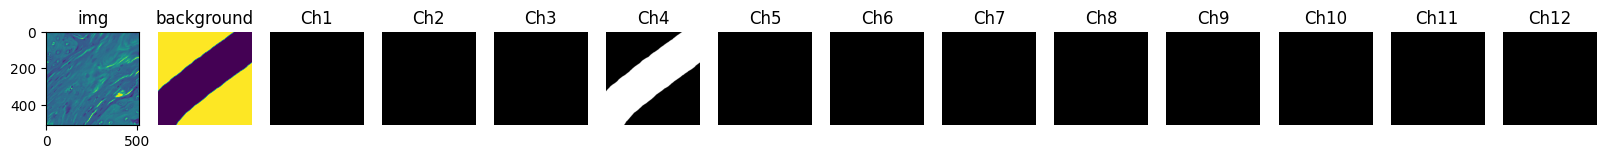

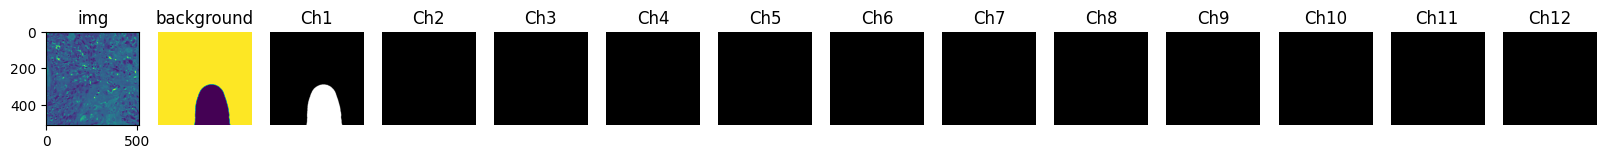

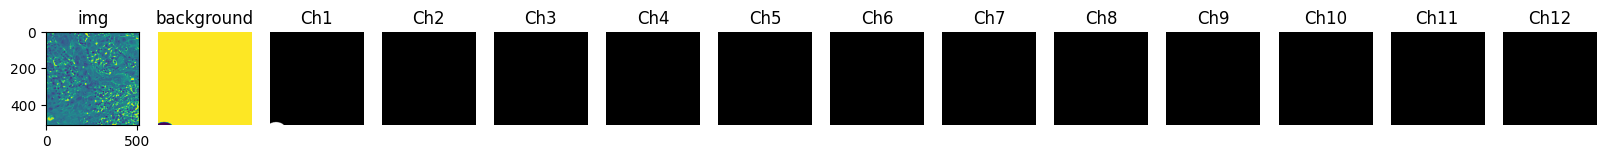

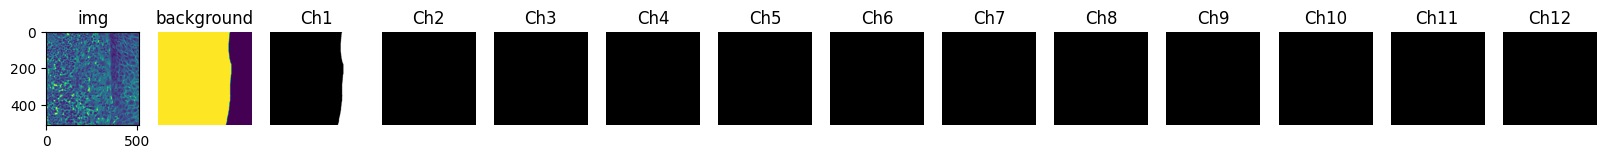

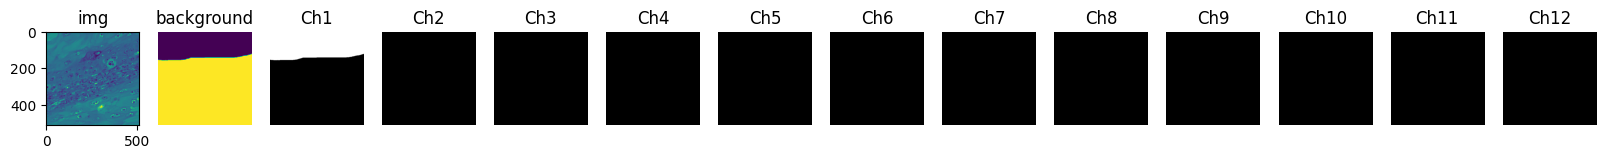

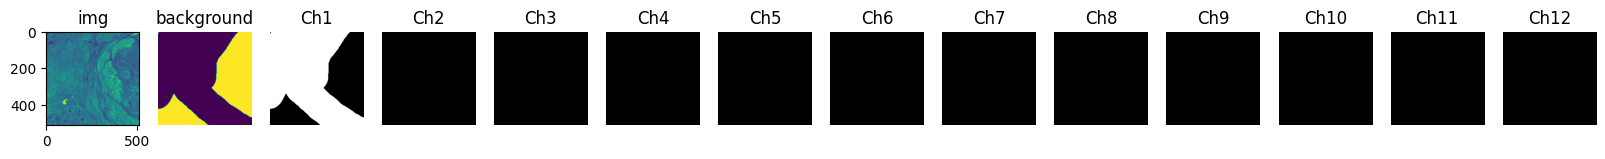

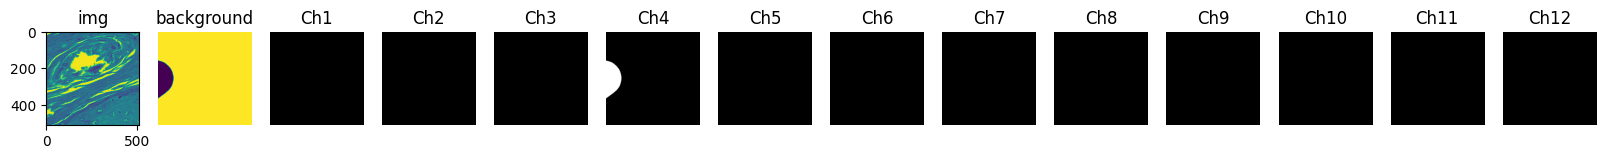

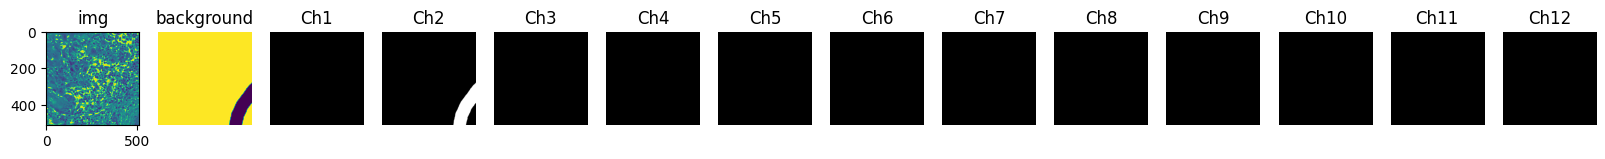

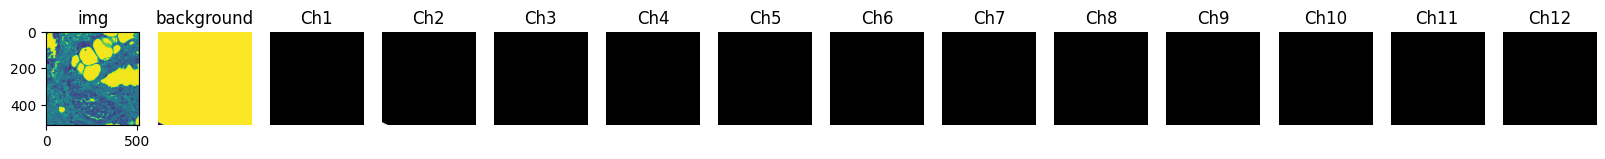

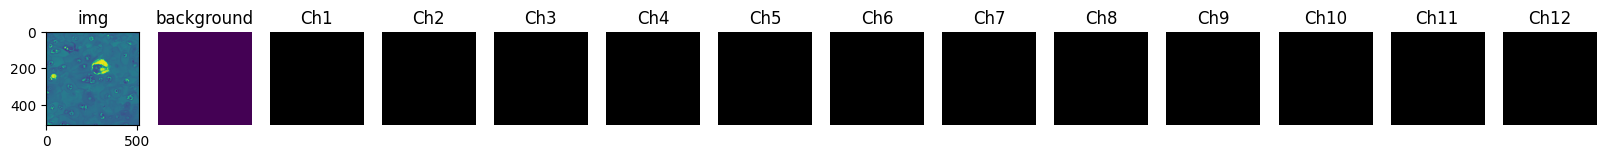

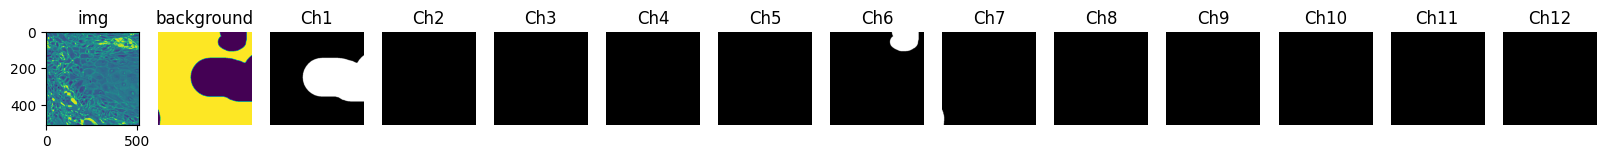

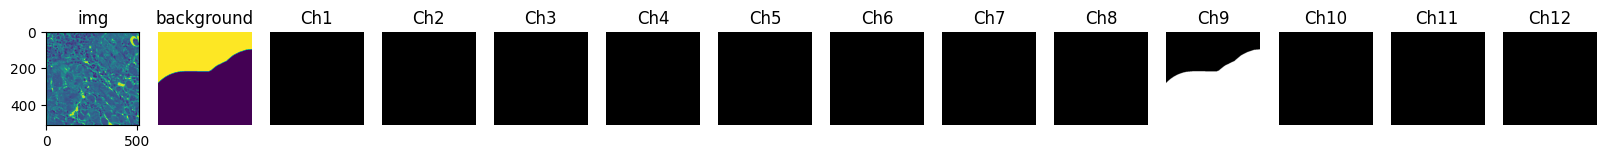

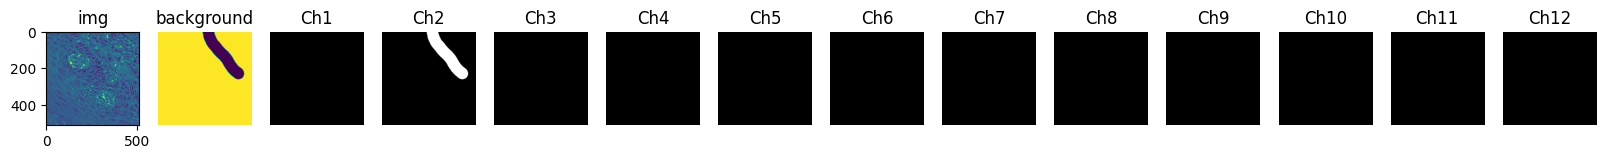

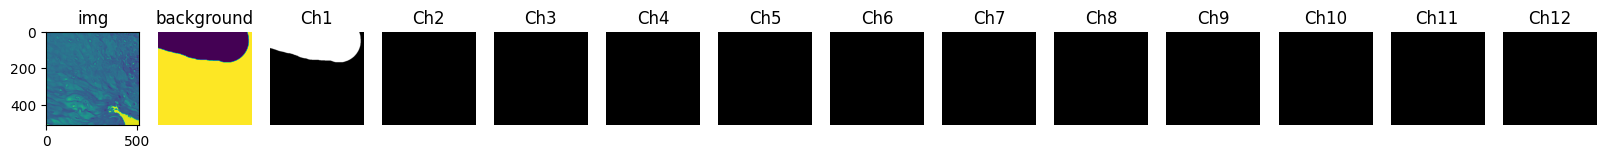

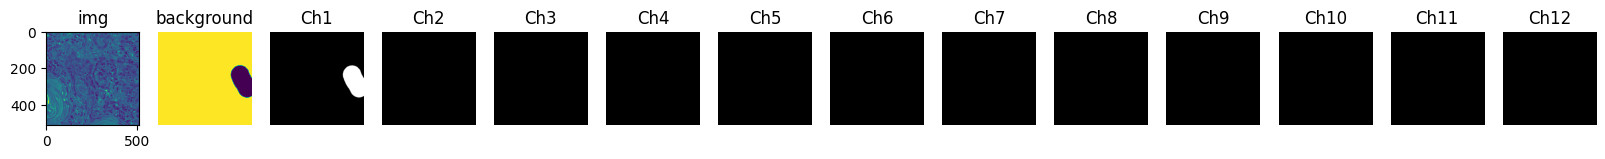

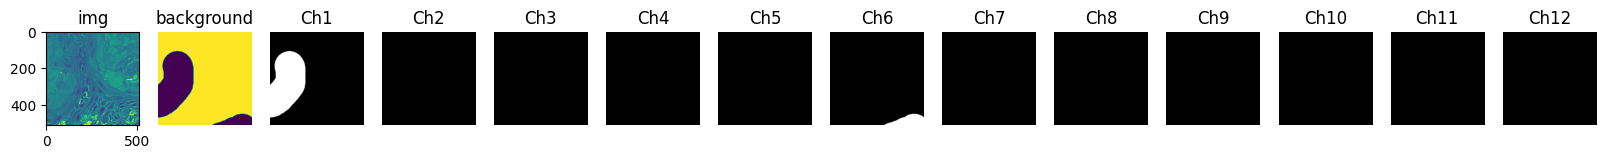

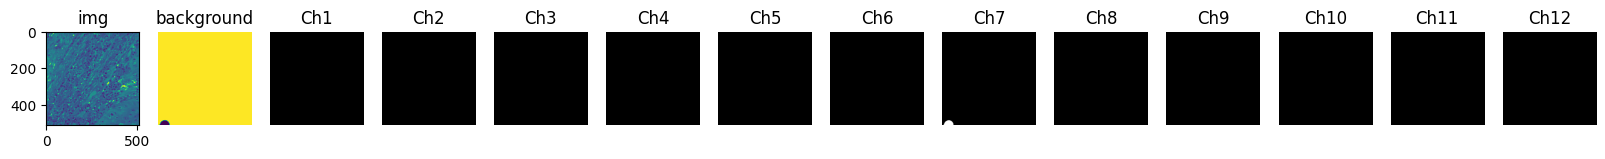

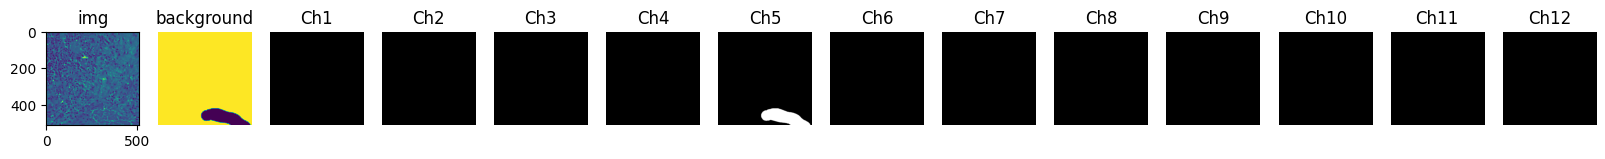

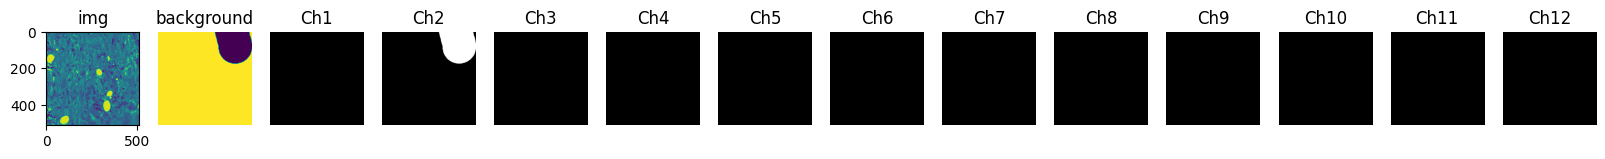

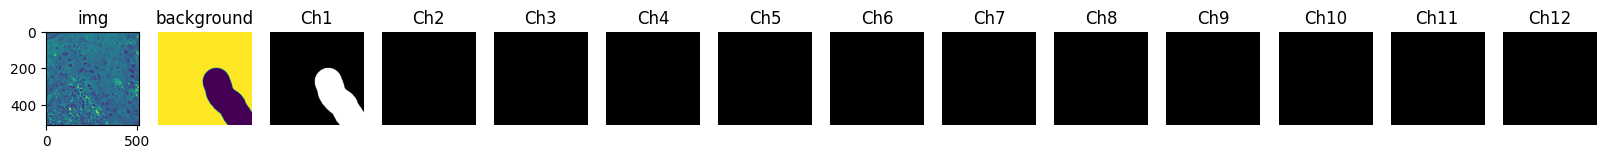

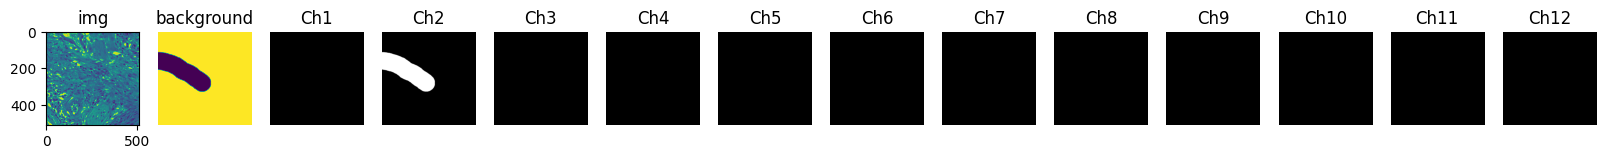

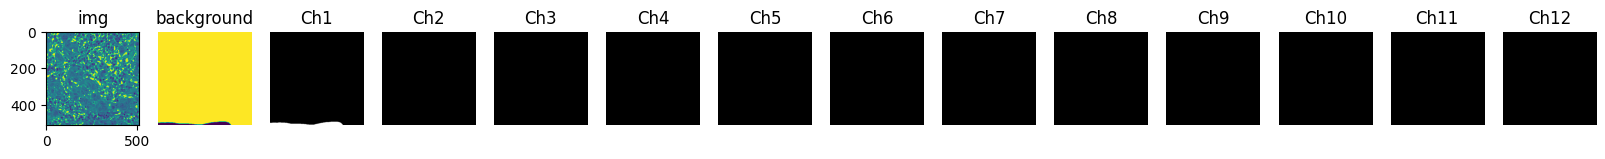

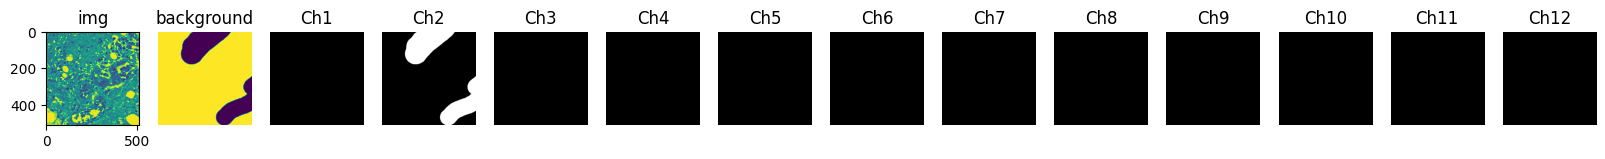

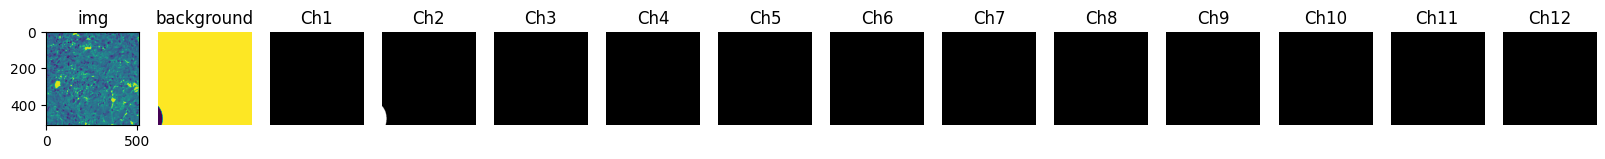

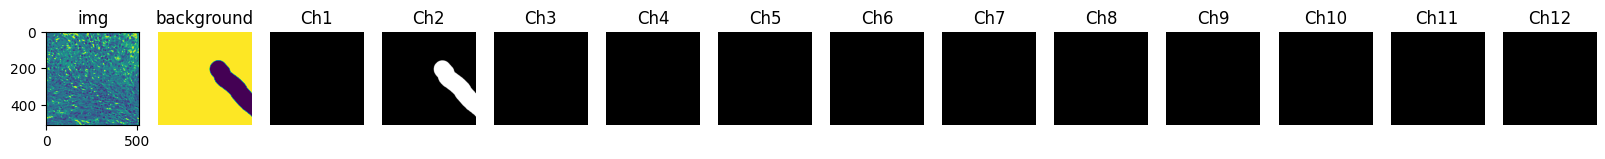

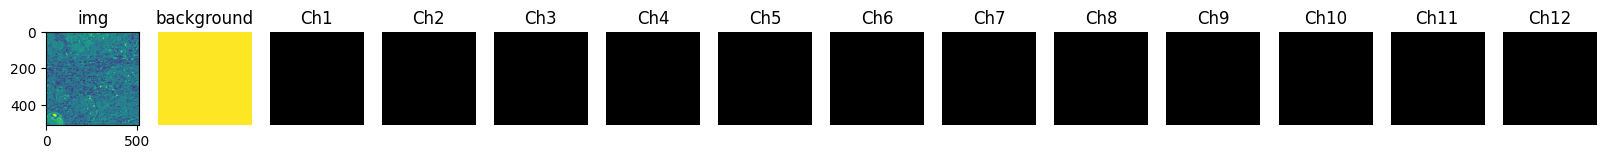

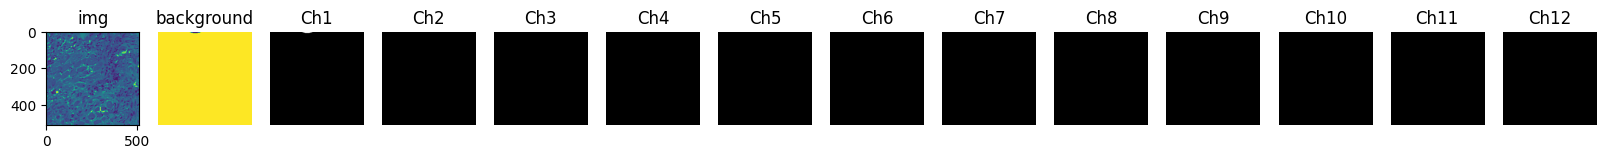

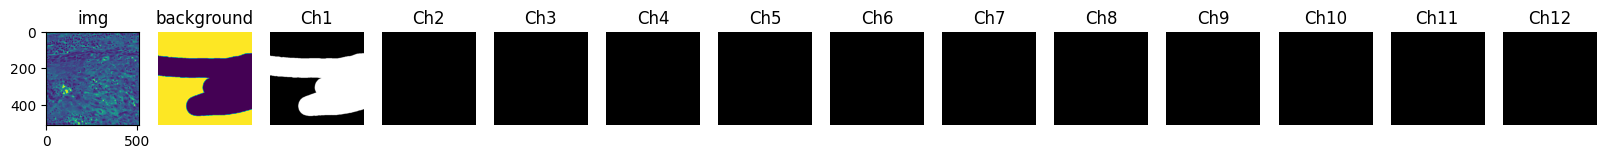

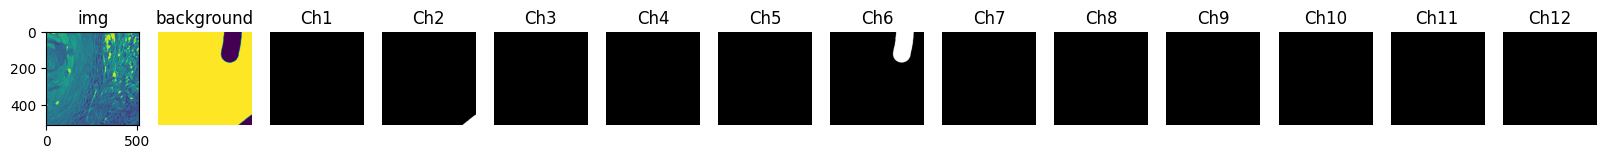

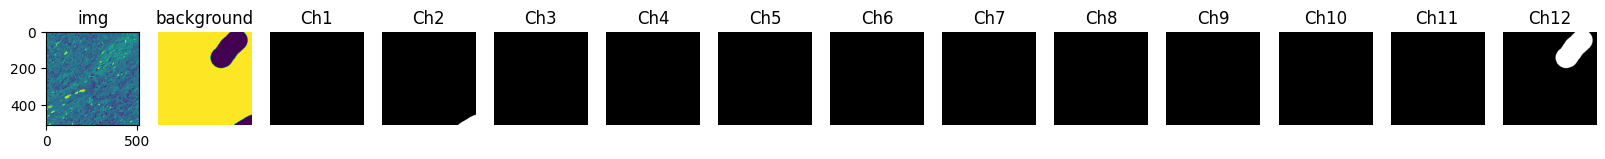

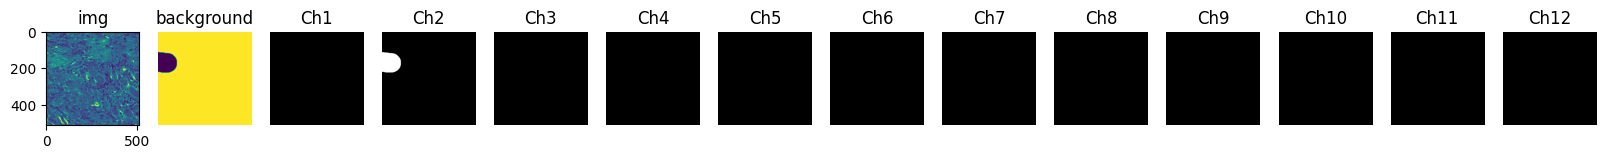

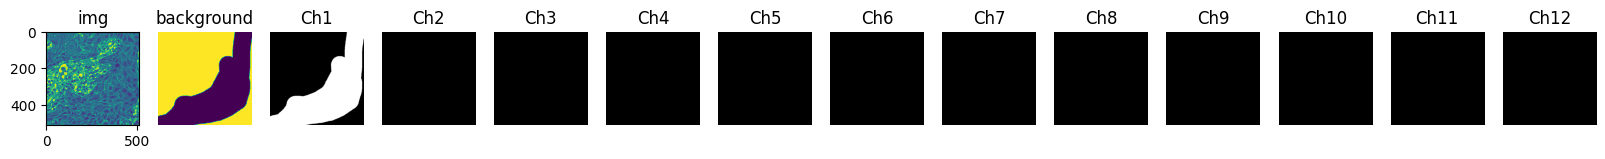

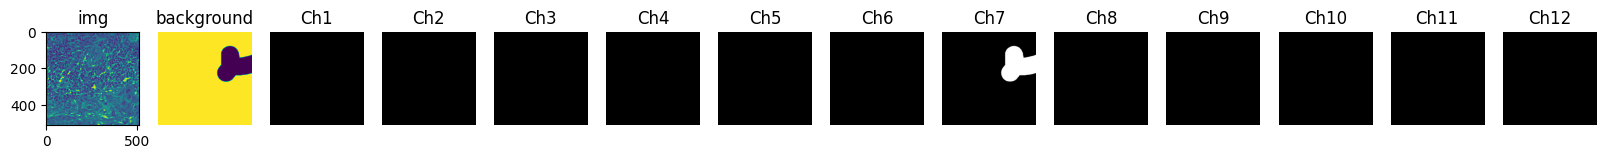

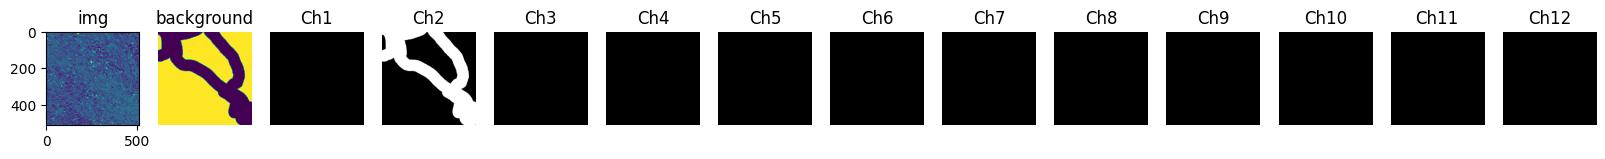

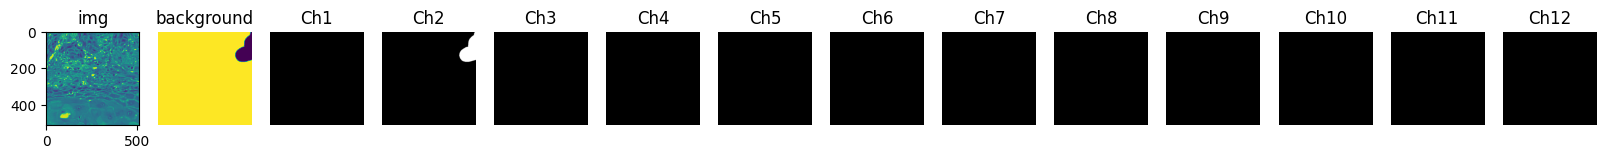

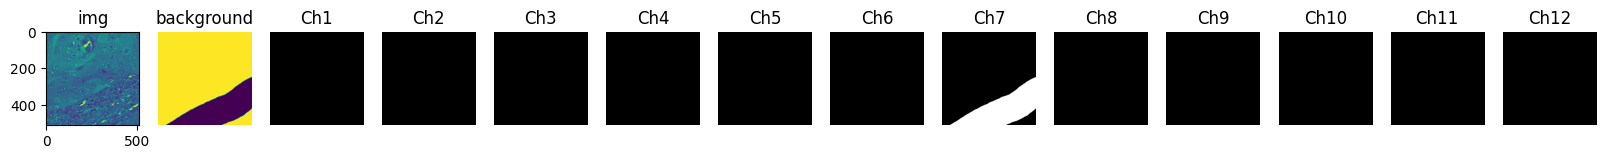

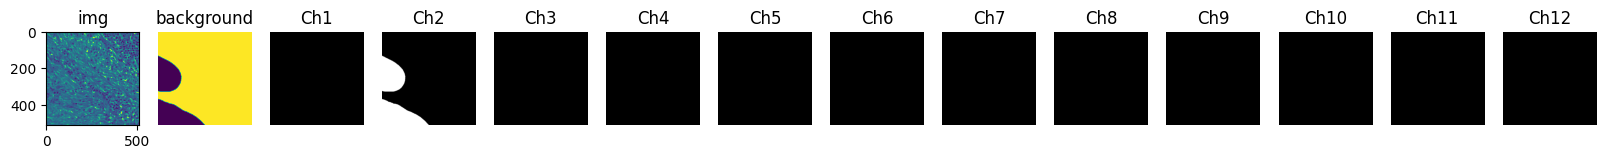

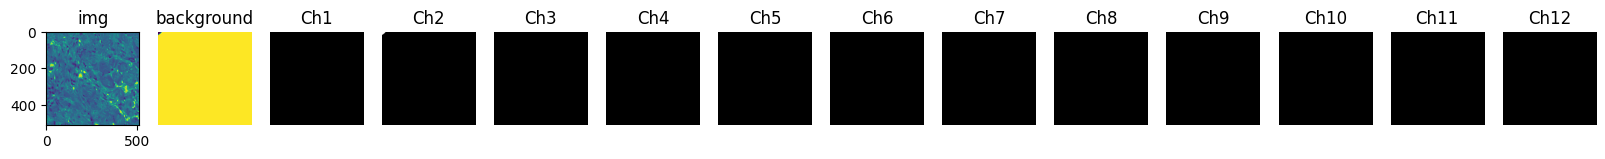

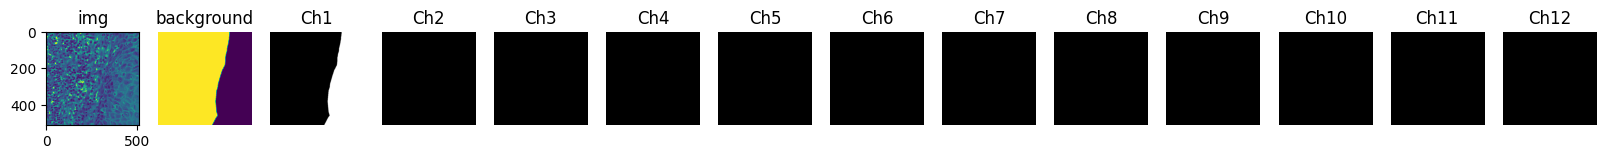

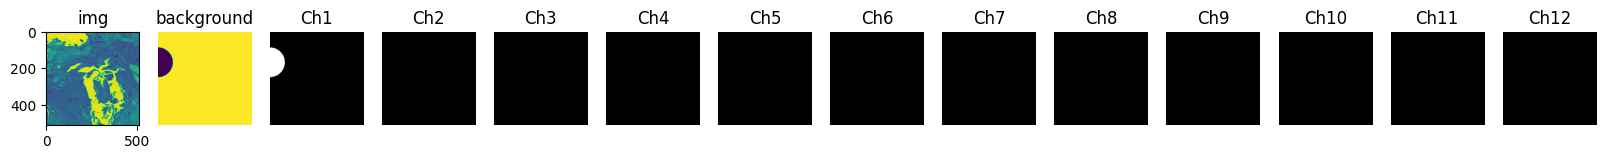

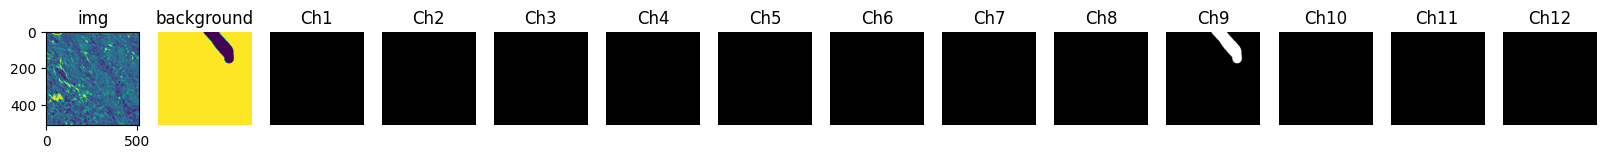

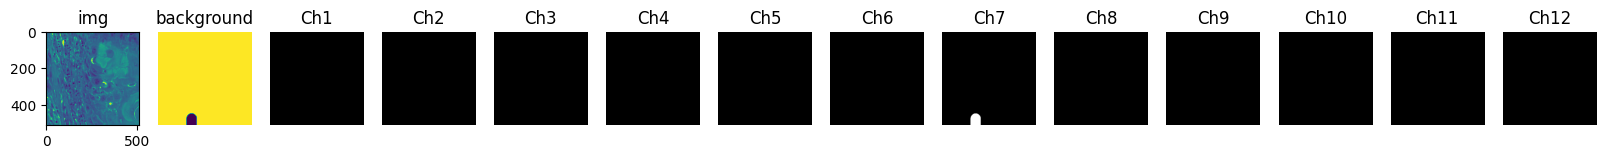

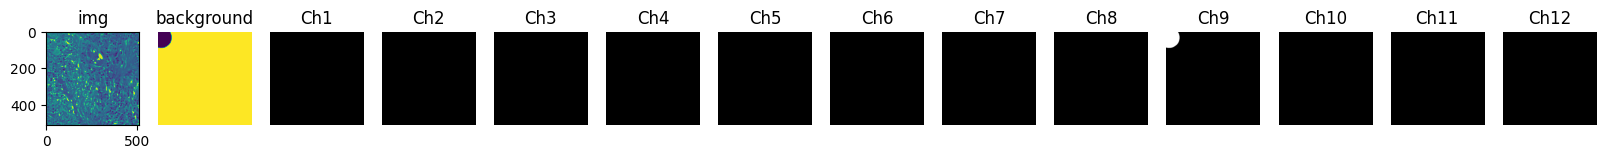

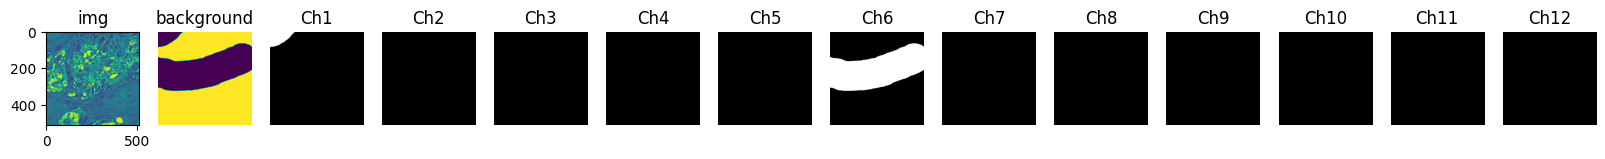

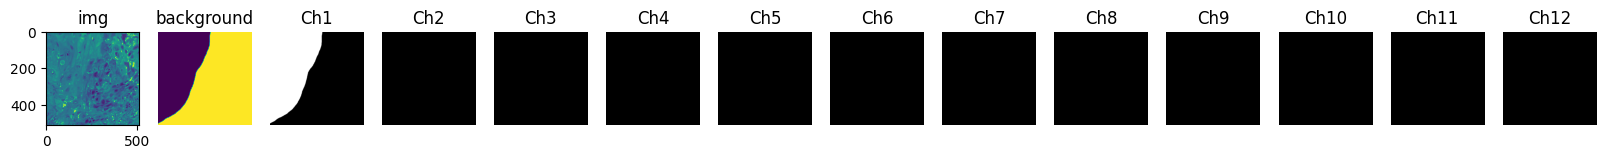

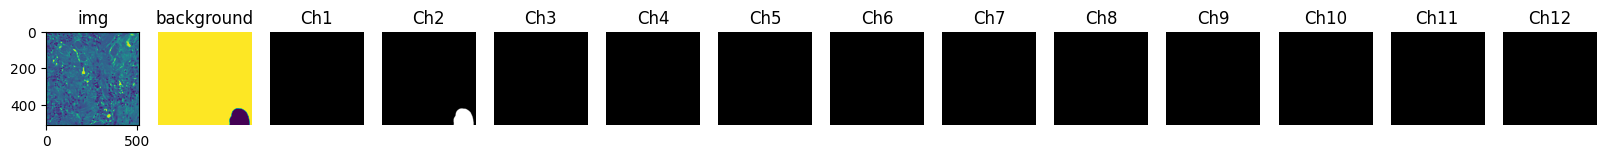

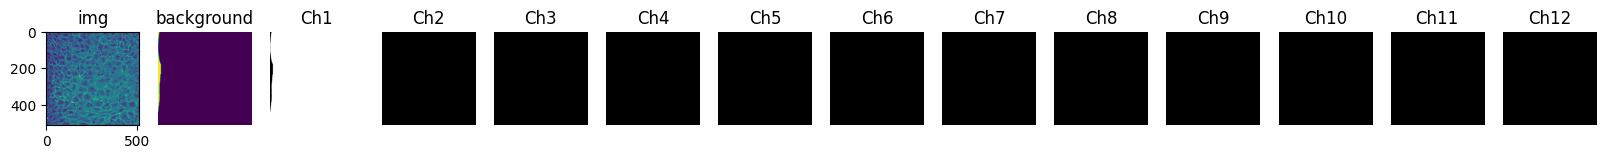

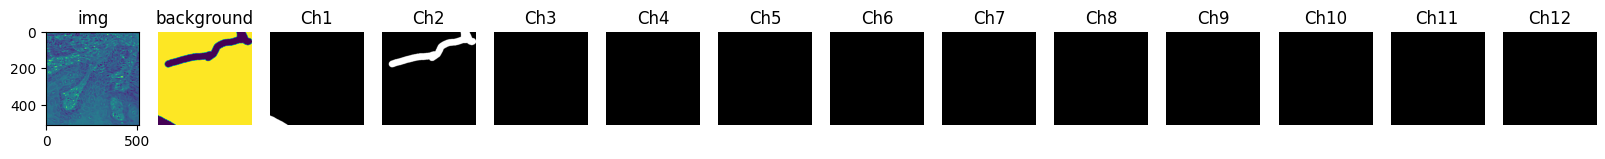

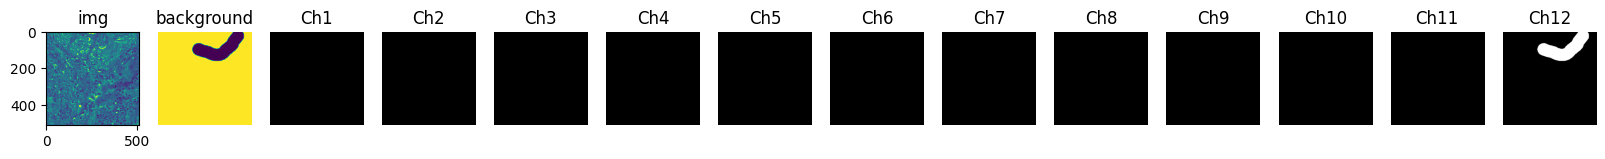

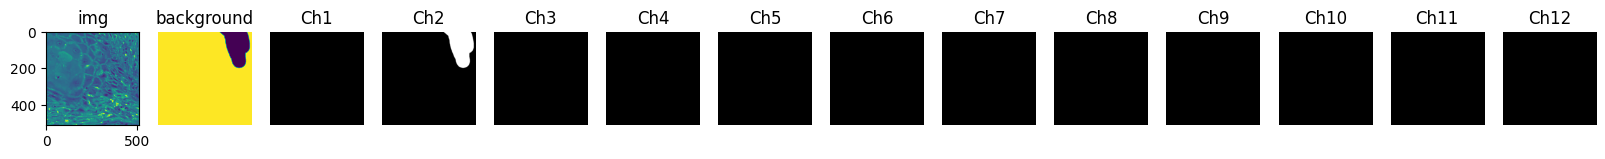

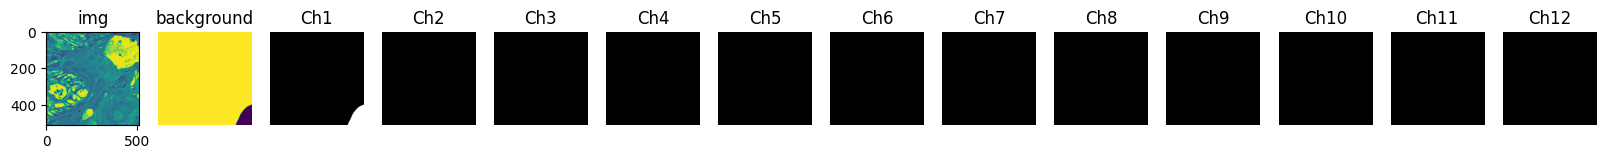

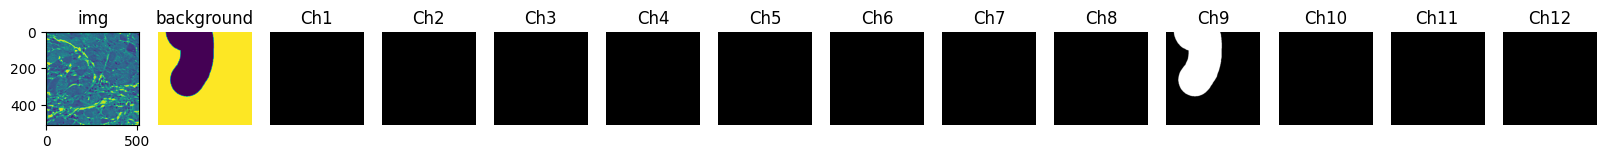

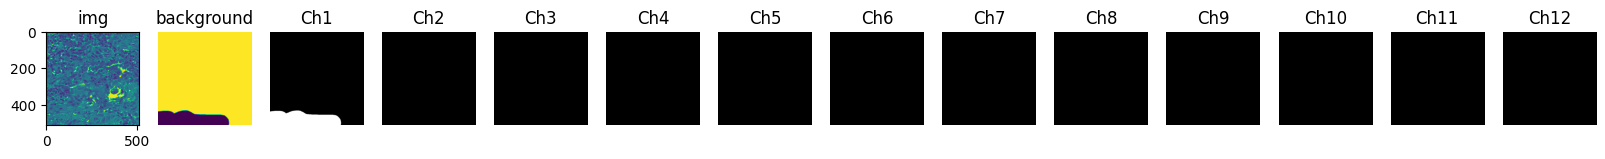

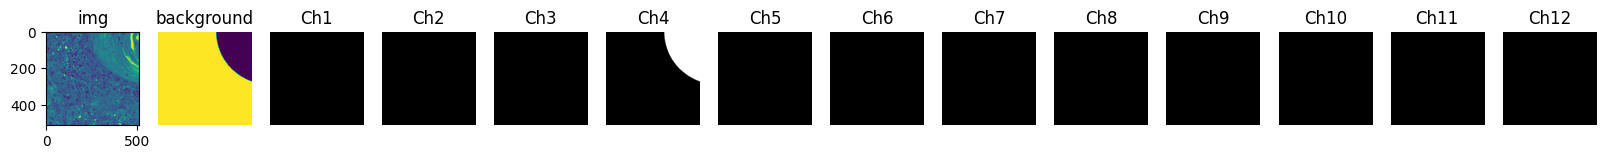

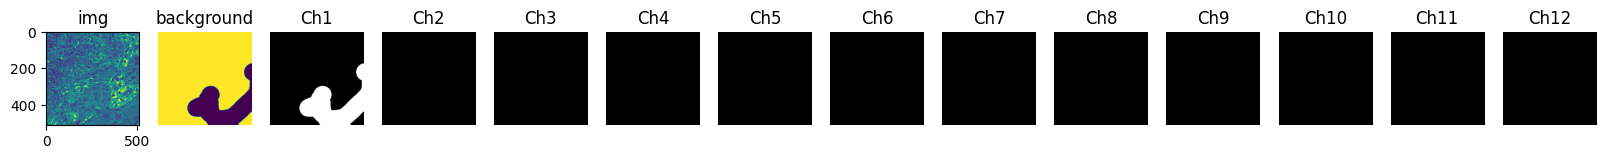

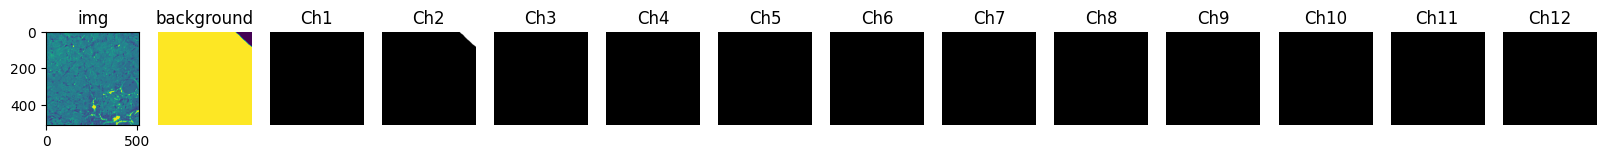

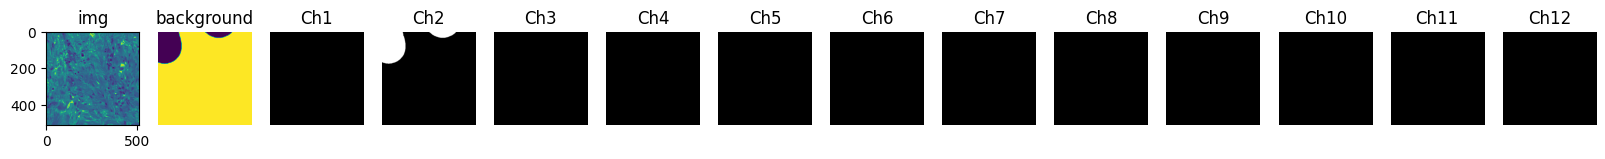

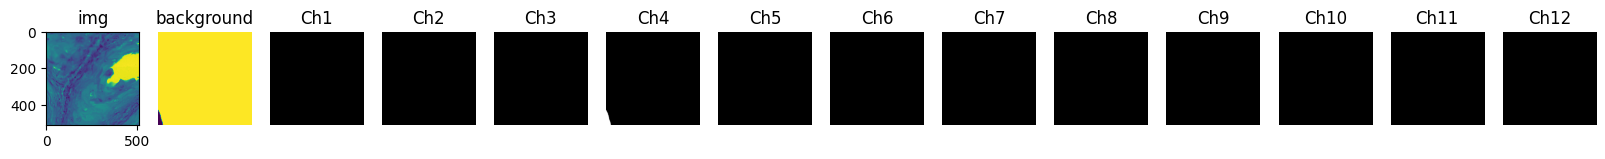

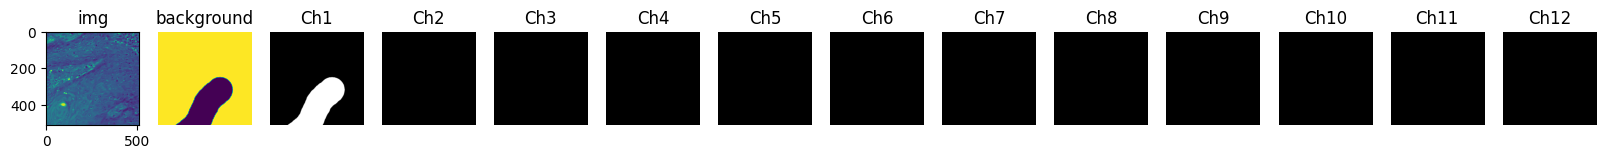

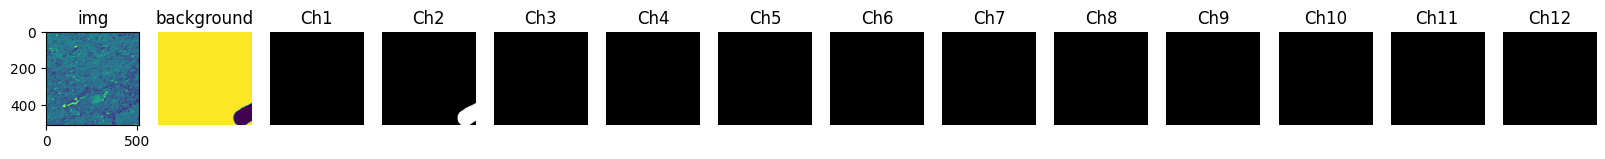

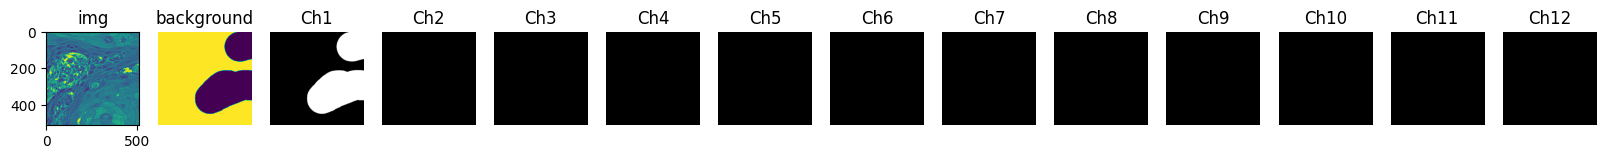

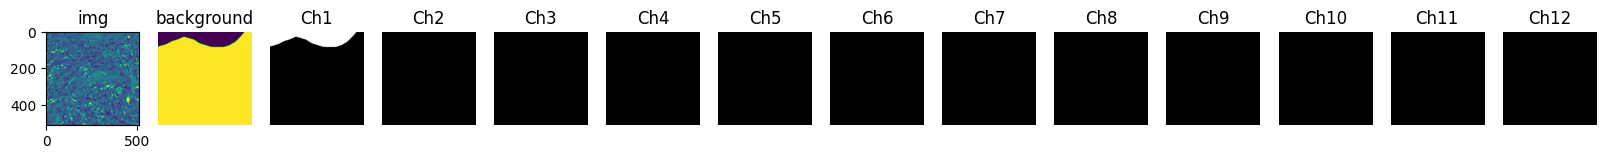

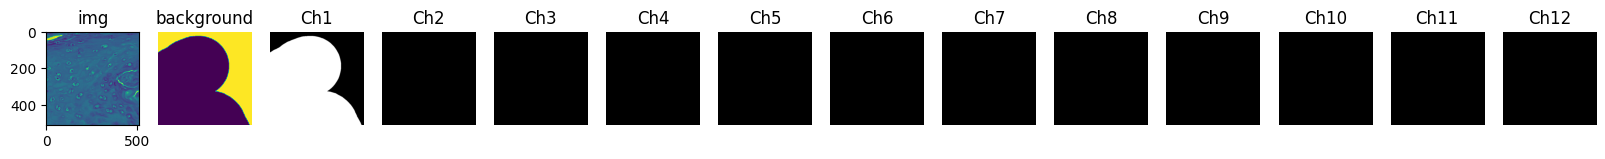

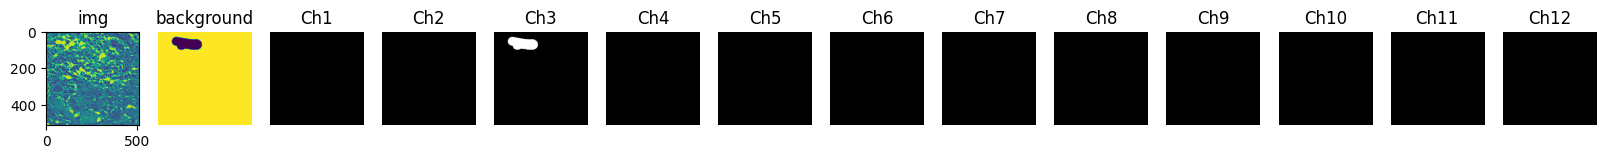

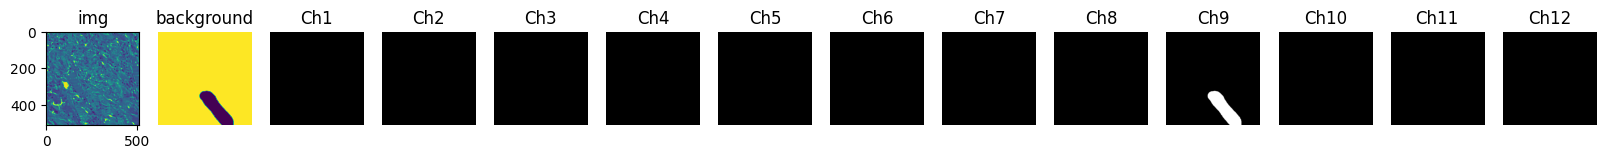

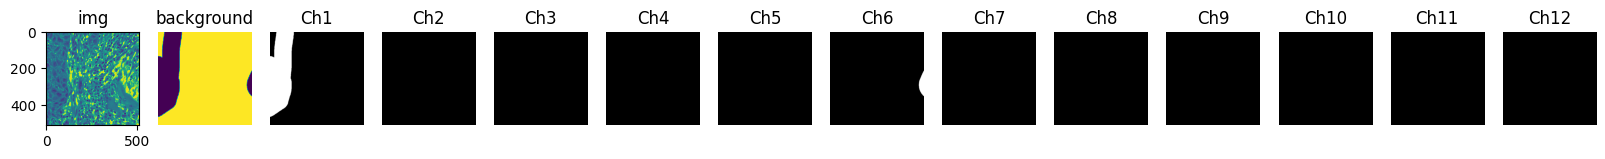

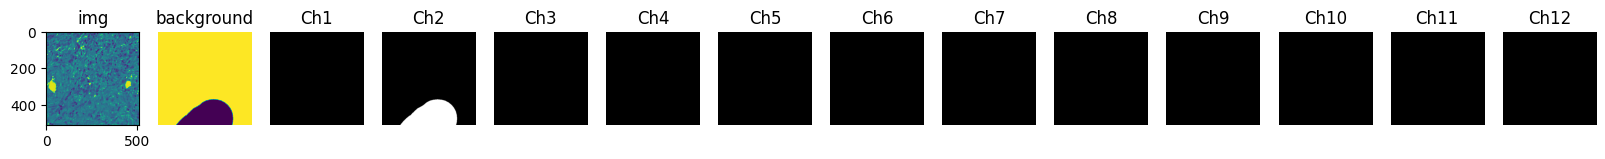

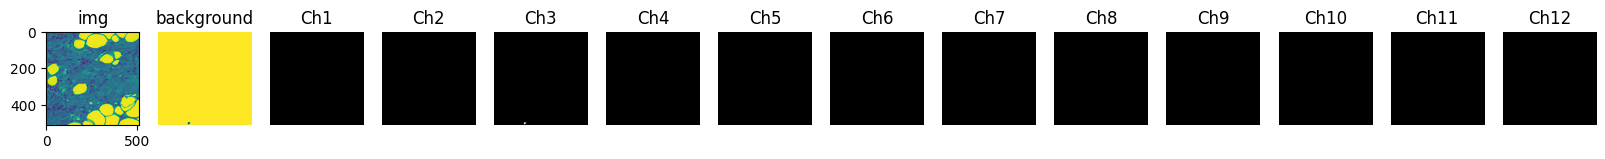

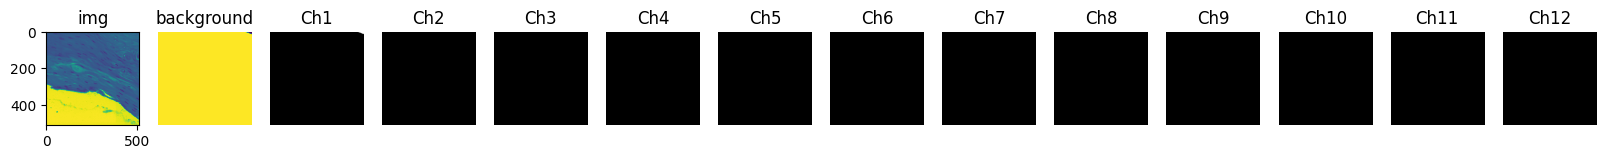

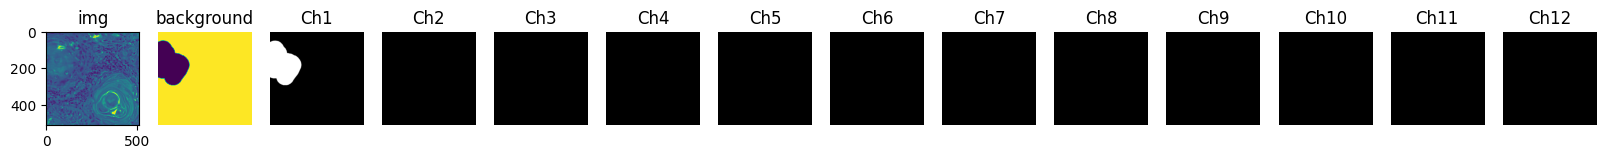

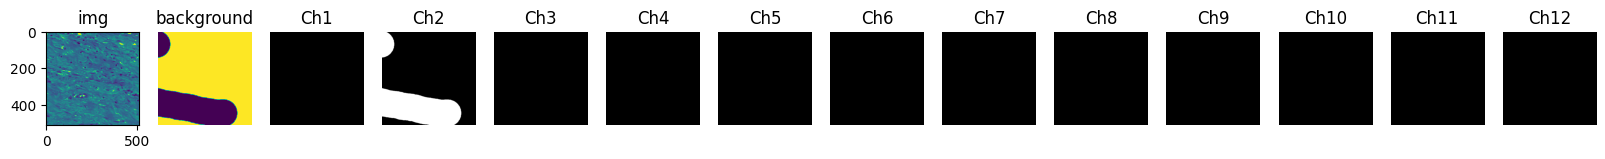

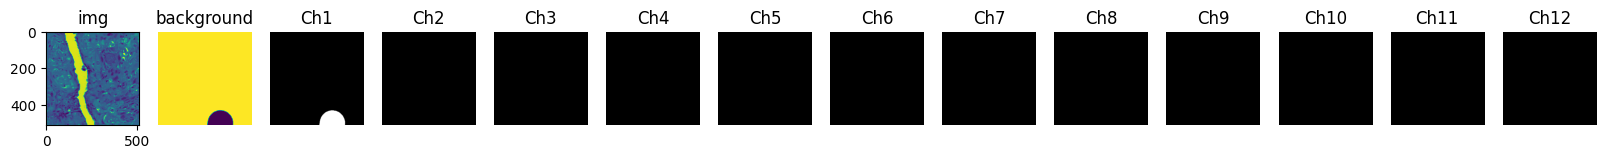

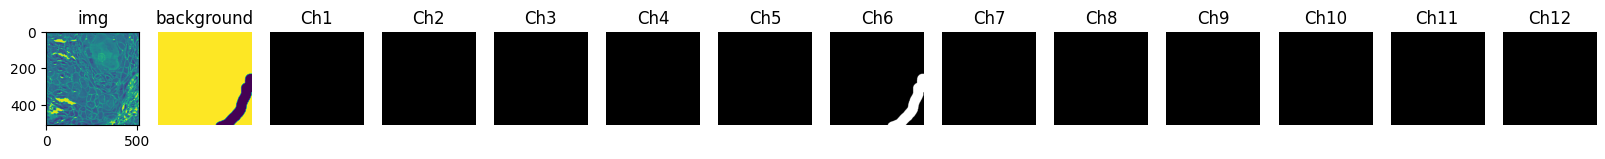

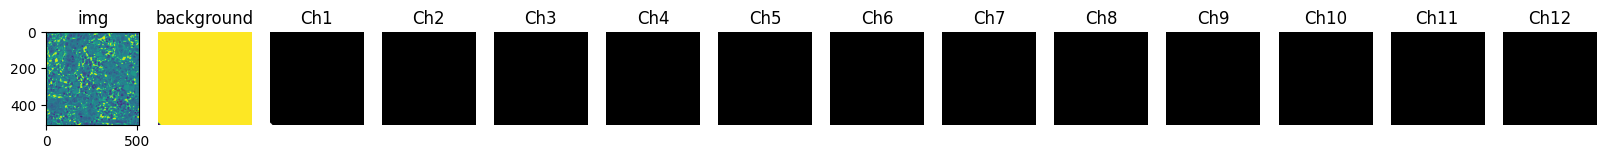

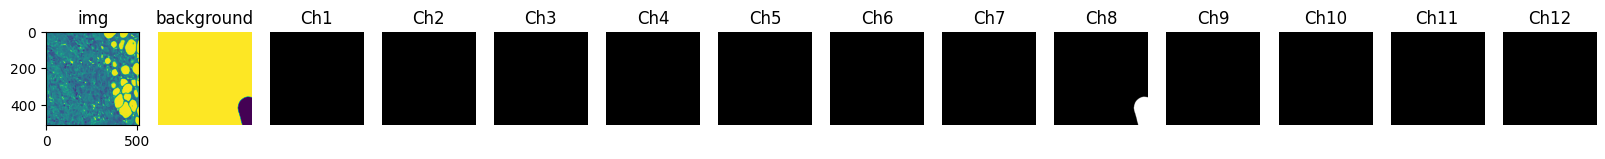

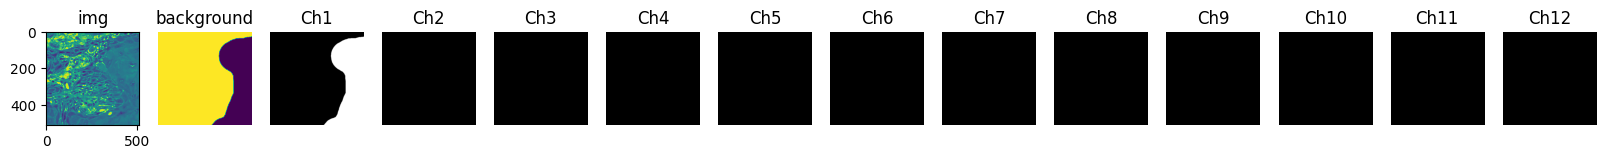

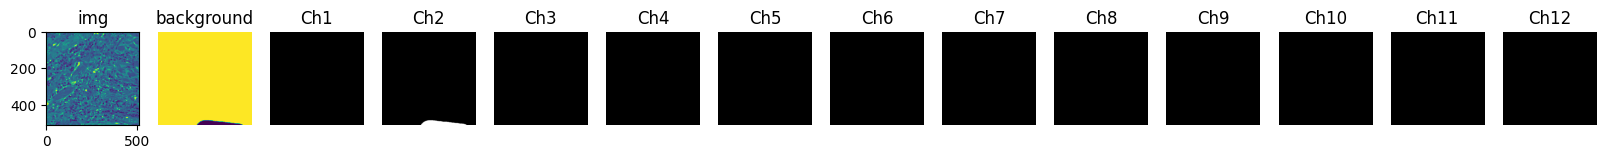

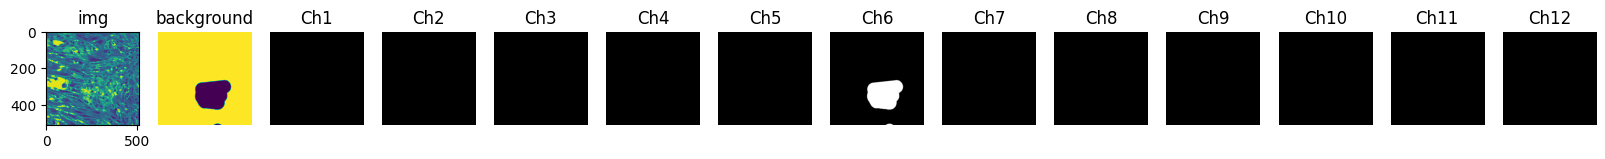

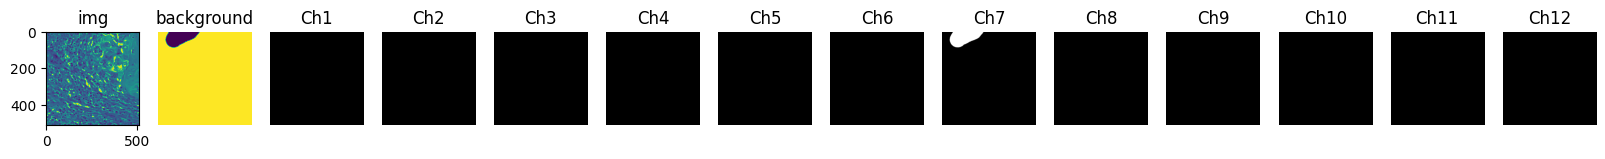

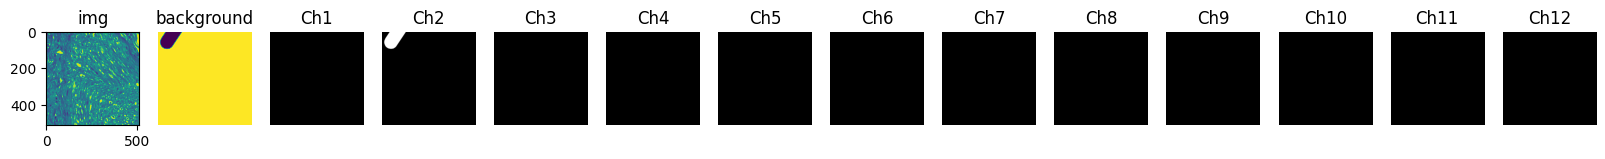

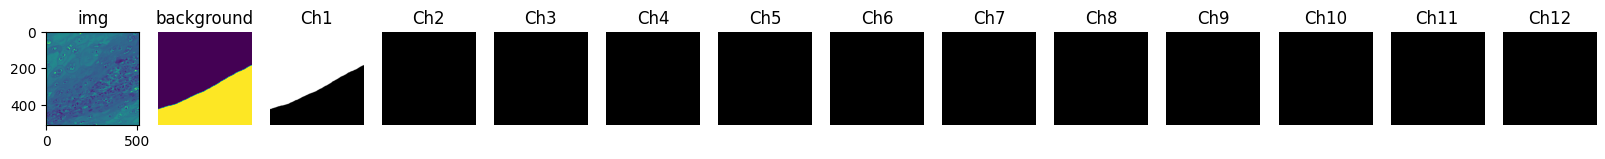

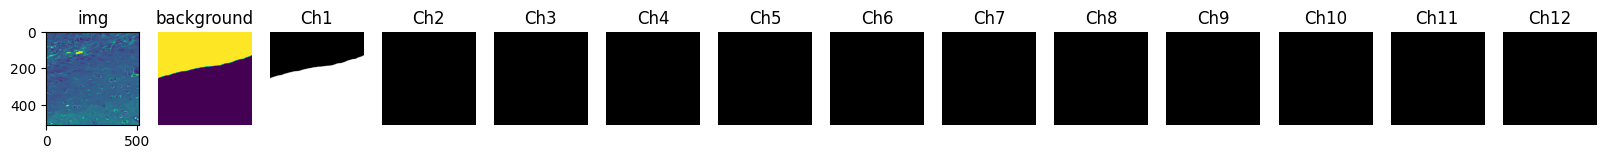

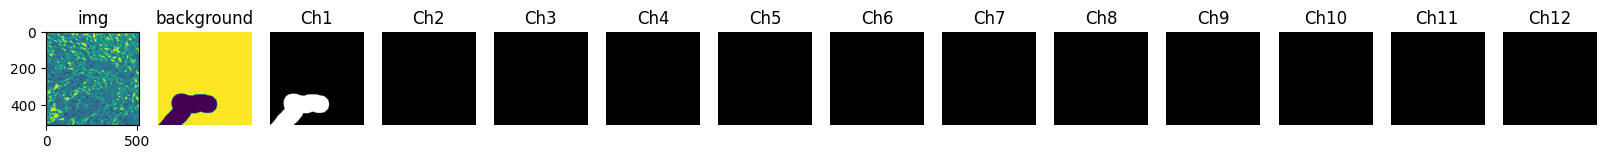

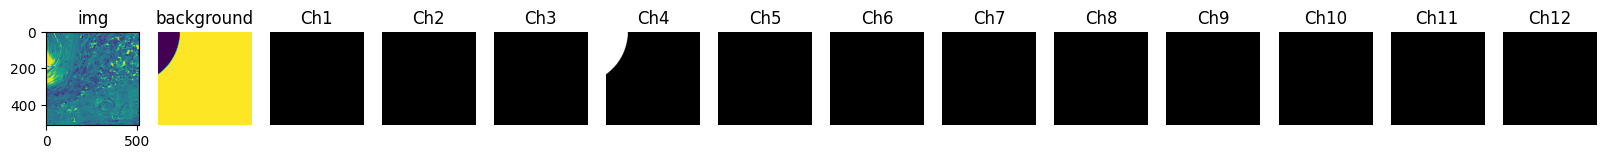

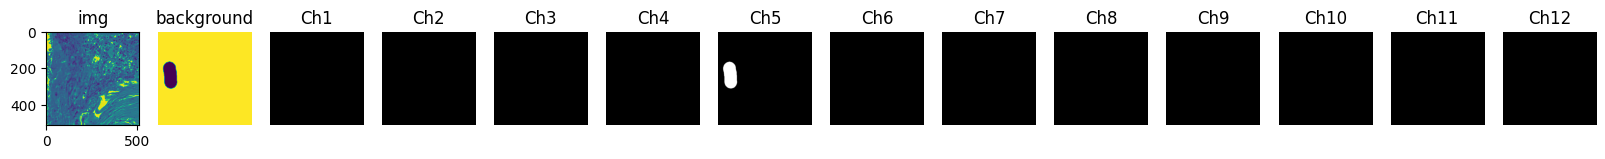

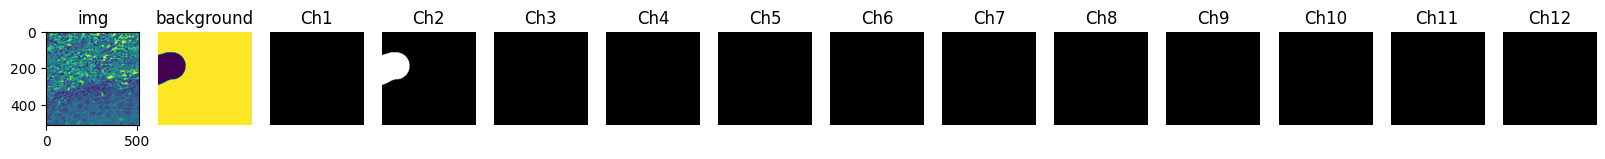

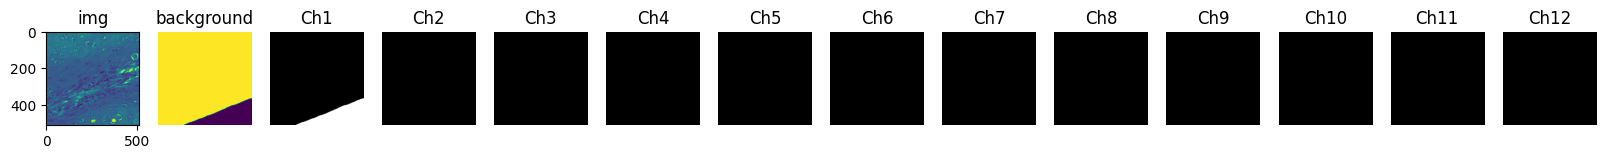

Batch shape (100, 512, 512) and for masks (100, 512, 512, 13)
image shape (512, 512) and for masks (512, 512, 13)
max value for images is 1.0 and for masks 255
min value for images is 0.1146245077252388 and for masks 0
number of unique values in images is 225 and for masks [  0   1 255]


In [179]:
test = DataGenerator(x,y,batch_size=100,aug=0)
a,b = test.__getitem__(0)
test.viz(a,b)

In [34]:
ls

 Datentr„ger in Laufwerk D: ist Volume
 Volumeseriennummer: E006-492A

 Verzeichnis von D:\Hamed

12.05.2023  13:47    <DIR>          .
12.05.2023  13:47    <DIR>          ..
13.12.2022  14:35    <DIR>          classifiers
14.12.2022  15:19    <DIR>          data
07.06.2023  17:36    <DIR>          Forschungsproject
07.06.2023  15:16    <DIR>          proj2
05.04.2023  16:13             7.727 project.qpproj
14.12.2022  15:38             7.727 project.qpproj.backup
05.04.2023  16:42         1.445.835 Screenshot 2023-04-05 164153.png
10.05.2023  15:28         1.695.783 Screenshot 2023-05-10 152812.png
               4 Datei(en),      3.157.072 Bytes
               6 Verzeichnis(se), 2.872.731.291.648 Bytes frei


NameError: name 'iPython' is not defined